# The Best linear unbiased predictor on a noisy Lotka-Volterra dynamical system

In [23]:
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
from numba import float32
from numba.experimental import jitclass

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

In [3]:
spec = [
    ("alpha", float32),
    ("beta", float32),
    ("delta", float32),
    ("gamma", float32),
    ("dt", float32),
    ("noise_latent", float32),
    ("noise_obs", float32)
]

@jitclass(spec)
class NoisyLotkaVolterra:
    def __init__(self, alpha, beta, delta, gamma, dt, noise_latent, noise_obs):
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.dt = dt
        self.noise_latent = noise_latent
        self.noise_obs = noise_obs

    def latent_step(params, z_prev):
        z1, z2 = z_prev
        # noise = jax.random.normal(key) * params.noise * jnp.sqrt(params.dt)
        noise = np.random.randn(2) * params.noise_obs * np.sqrt(params.dt)
        
        z1_next = params.alpha * z1 - params.beta * z1 * z2
        z2_next = params.delta * z1 * z2 - params.gamma * z2
        z_next = np.array([z1_next, z2_next])
        z_next = z_prev + params.dt * z_next + noise
        
        return z_next

    def observed_step(self, z_next):
        noise = np.random.randn(2) * self.noise_latent
        y_next = z_next + noise
        return y_next

    def step(self, z_prev):
        z_next = self.latent_step(z_prev)
        y_next = self.observed_step(z_next)

        return z_next, y_next

    def run_sim(self, seed, z_init, n_steps):
        np.random.seed(seed)
        latent_hist = np.zeros((n_steps, 2))
        observed_hist = np.zeros((n_steps, 2))
        
        z = z_init.copy()
        for n in range(n_steps):
            z, y = self.step(z)
            latent_hist[n] = z
            observed_hist[n] = y
            seed += 1

        return latent_hist, observed_hist

In [4]:
model = NoisyLotkaVolterra(
    alpha=2/3, beta=4/3, delta=1, gamma=1, dt=0.01, noise_latent=0.04, noise_obs=0.05,
)

In [5]:
z = np.array([1.0, 1.0])
model.step(z)

(array([0.9894652 , 1.00122602]), array([0.94531707, 0.95734032]))

In [6]:
seed = 316
n_steps = 1_000
Z, Y = model.run_sim(seed, z, n_steps)

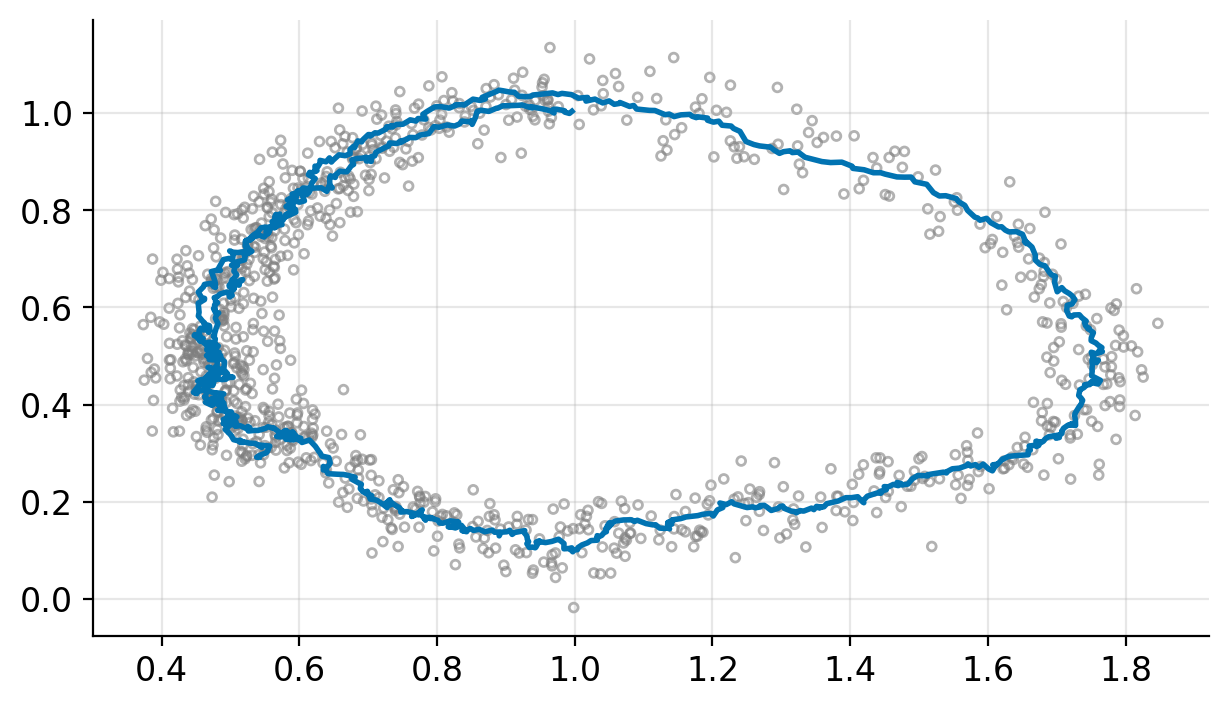

In [7]:
plt.plot(*Z.T, linewidth=2)
plt.scatter(*Y.T, color="none", edgecolor="tab:gray", s=10, alpha=0.6)
plt.grid(alpha=0.3)

# Jax

In [8]:
import jax
import chex
import jax.numpy as jnp
from functools import partial

In [9]:
@chex.dataclass
class ParamsLatent:
    alpha: float
    beta: float
    delta: float
    gamma: float
    dt: float
    noise: float


@chex.dataclass
class ParamsObserved:
    noise: float

In [10]:
def latent_step(key, z_prev, params):
    z1, z2 = z_prev
    noise = jax.random.normal(key) * params.noise * jnp.sqrt(params.dt)
    
    z1_next = params.alpha * z1 - params.beta * z1 * z2
    z2_next = params.delta * z1 * z2 - params.gamma * z2
    z_next = jnp.array([z1_next, z2_next])
    
    z_next = z_prev + params.dt * z_next + noise
    
    return z_next


def observed_step(key, z_val, params):
    """
    Observed step is simply the current latent
    observed value + gaussian noise
    """
    noise = jax.random.normal(key, (2,)) * params.noise
    obs = z_val + noise
    return obs


def step_latent_observed(z_prev, key, latent_fn, observed_fn,
                             params_latent, params_obs):
    key_latent, key_obs = jax.random.split(key)
    
    z_next = latent_fn(key_latent, z_prev, params_latent)
    x_next = observed_step(key_obs, z_next, params_obs)
    
    res = {
        "latent": z_next,
        "observed": x_next
    }
    return z_next, res
    

def simulate_latent_observed(key, z0, n_steps, latent_fn, observed_fn,
                             params_latent, params_obs):
    keys = jax.random.split(key, n_steps)
    part_step_latent_obs = partial(step_latent_observed,
                                   latent_fn=latent_fn,
                                   observed_fn=observed_fn,
                                   params_latent=params_latent,
                                   params_obs=params_obs)
    
    _, hist = jax.lax.scan(part_step_latent_obs, z0, keys)
    return hist


multiple_simulate_latent_observed = jax.vmap(
    simulate_latent_observed,
    in_axes=(0, None, None, None, None, None, None),
    out_axes=-1
)

In [573]:
key = jax.random.PRNGKey(314)
z0 = jnp.array([1.0, 1.0])
params_latent = ParamsLatent(alpha=2/3, beta=4/3, delta=0.8, gamma=1, dt=0.01, noise=0.04)
params_obs = ParamsObserved(noise=0.07)

n_steps = 1500
n_simulations = 24
keys = jax.random.split(key, n_simulations)

simulations = multiple_simulate_latent_observed(keys, z0, n_steps, latent_step, observed_step,
                                                params_latent, params_obs)

latent_sims = simulations["latent"]
measured_sims = simulations["observed"]

*_, dim_latent = latent_sims.shape
*_, dim_inputs = measured_sims.shape

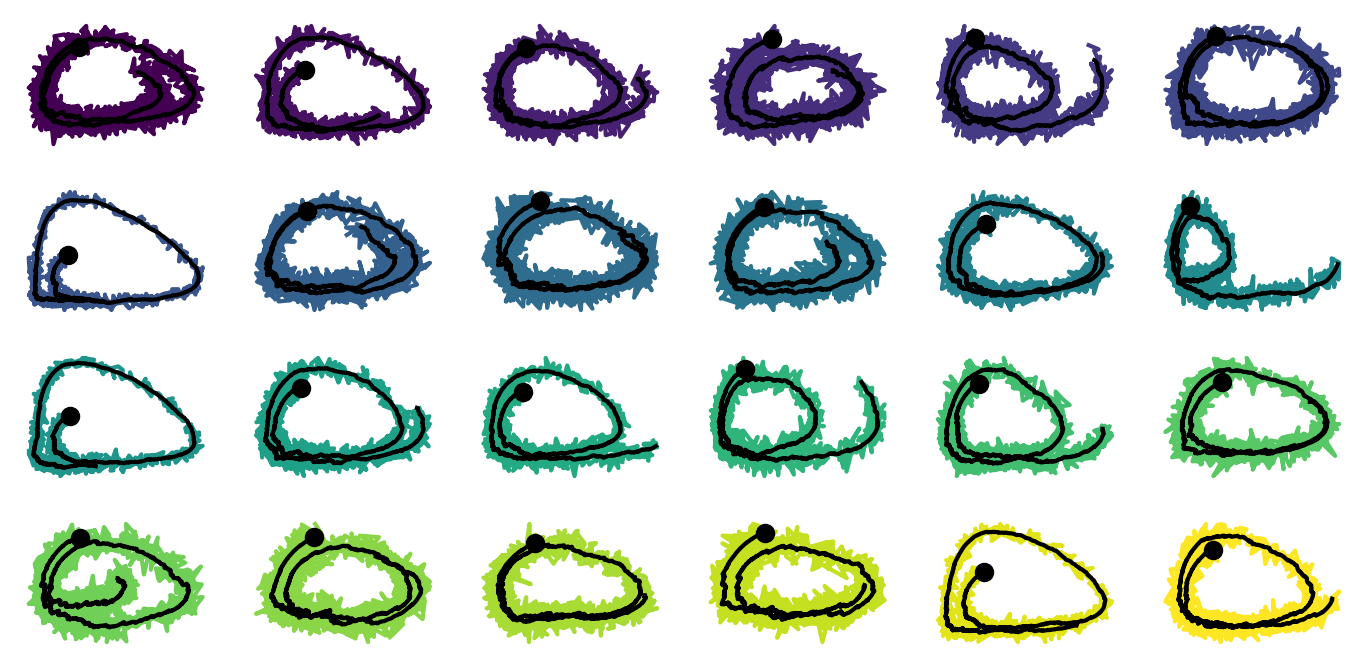

In [575]:
fig, axs = plt.subplots(4, 6, figsize=(7, 3.5))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_simulations))

axs = axs.ravel()
for n, ax in enumerate(axs):
    z_sim = latent_sims[..., n]
    x_sim = measured_sims[..., n]
    ax.plot(*x_sim.T, c=colors[n], zorder=0)
    ax.plot(*z_sim.T, c="black", zorder=1)
    ax.scatter(*z0, c="black", zorder=2)
    ax.axis("off")
plt.tight_layout()
plt.savefig("samples-process.png", dpi=300, bbox_inches="tight")

## More simulations

In [403]:
latent_sims.shape

(1500, 2, 25)

In [451]:
key = jax.random.PRNGKey(314)
z0 = jnp.array([1.0, 1.0])
params_latent = ParamsLatent(alpha=2/3, beta=4/3, delta=0.8, gamma=1, dt=0.01, noise=0.02)
params_obs = ParamsObserved(noise=0.05)

n_steps = 1500
n_test = 100
n_simulations = 10_000 + n_test
keys = jax.random.split(key, n_simulations)

simulations = multiple_simulate_latent_observed(keys, z0, n_steps, latent_step, observed_step,
                                                params_latent, params_obs)

latent_sims = simulations["latent"]
measured_sims = simulations["observed"]

latent_sims = latent_sims - latent_sims.mean(axis=-1, keepdims=True)
measured_sims = measured_sims - measured_sims.mean(axis=-1, keepdims=True)

latent_sims_test = latent_sims[..., -n_test:]
measured_sims_test = measured_sims[..., -n_test:]

latent_sims = latent_sims[..., :-n_test]
measured_sims = measured_sims[..., :-n_test]

*_, dim_latent = latent_sims.shape
*_, dim_inputs = measured_sims.shape

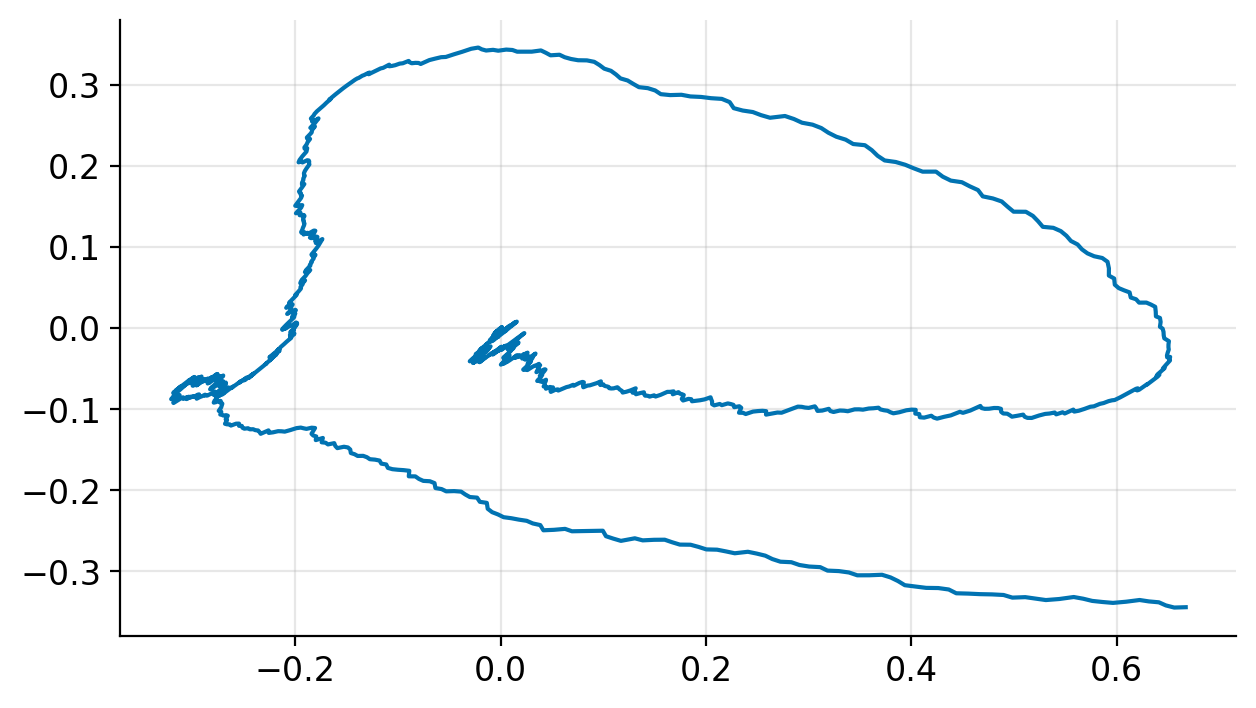

In [452]:
s = 0
plt.plot(*latent_sims[..., s].T)
plt.grid(alpha=0.3)

In [453]:
measured_mean = measured_sims.mean(axis=-1, keepdims=True)

In [454]:
# Covariance
measured_sims_demeaned = measured_sims - measured_mean
V = jnp.einsum("ids,jds->dij", measured_sims_demeaned, measured_sims_demeaned) / (n_simulations - 1)
V.shape

(2, 1500, 1500)

In [455]:
L = jnp.linalg.cholesky(V)
S = jnp.einsum("dii->di", L)
L = jnp.einsum("dij,dj->dij", L, 1 / S)
S = S ** 2

## Matching variance
$$
    {\rm Var}(y_{1:T}) = {\bf L}\,{\bf S}\,{\bf L}^\intercal,
$$
with
${\bf S} = {\rm diag}(S_1, \ldots, S_T)$, and $S_k = {\rm Var}(\varepsilon_k)$.

In [456]:
# Variance of measurements
jnp.einsum("dii->d", V)

Array([27.236977,  8.689754], dtype=float32)

In [457]:
# Reconstructed trace of variance from Cholesky
jnp.einsum("dij,dj,dij->d", L, S, L)

Array([27.236961,  8.689753], dtype=float32)

In [458]:
measured_sims.shape

(1500, 2, 10000)

# Computing the BLUP

## Building innovations
$$
    {\bf L}\,\varepsilon_{1:T} = y_{1:T} \implies \varepsilon_t = {\bf L}^{-1}\,y_{1:T}
$$

In [471]:
# Train phase
innovation_sims = jnp.linalg.solve(L, einops.rearrange(measured_sims, "t d s -> d t s"))
innovation_sims = einops.rearrange(innovation_sims, "d t s -> t d s")

## The gain matrix
Recall that the *gain* matrix is defined by
$$
\begin{aligned}
    {\bf K}_{t,k}
    &= {\rm Cov}(F_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\\
    &= {\rm Cov}(F_t, {\cal E}_k)\,S_k^{-1}
\end{aligned}
$$

In [460]:
latent_mean = latent_sims.mean(axis=-1, keepdims=True)
innovation_mean = innovation_sims.mean(axis=-1, keepdims=True)

latent_demean = latent_sims - latent_mean
innovation_demean = innovation_sims - innovation_mean
K = jnp.einsum("ids,jds->ijd", latent_demean, innovation_demean) / (n_simulations - 1)
K.shape

(1500, 1500, 2)

# Test filter

In [473]:
## Build innovations
innovation_sims_test = jnp.linalg.solve(L, einops.rearrange(measured_sims_test, "t d s -> d t s"))
innovation_sims_test = einops.rearrange(innovation_sims_test, "d t s -> t d s")
innovation_sims_test.shape

(1500, 2, 100)

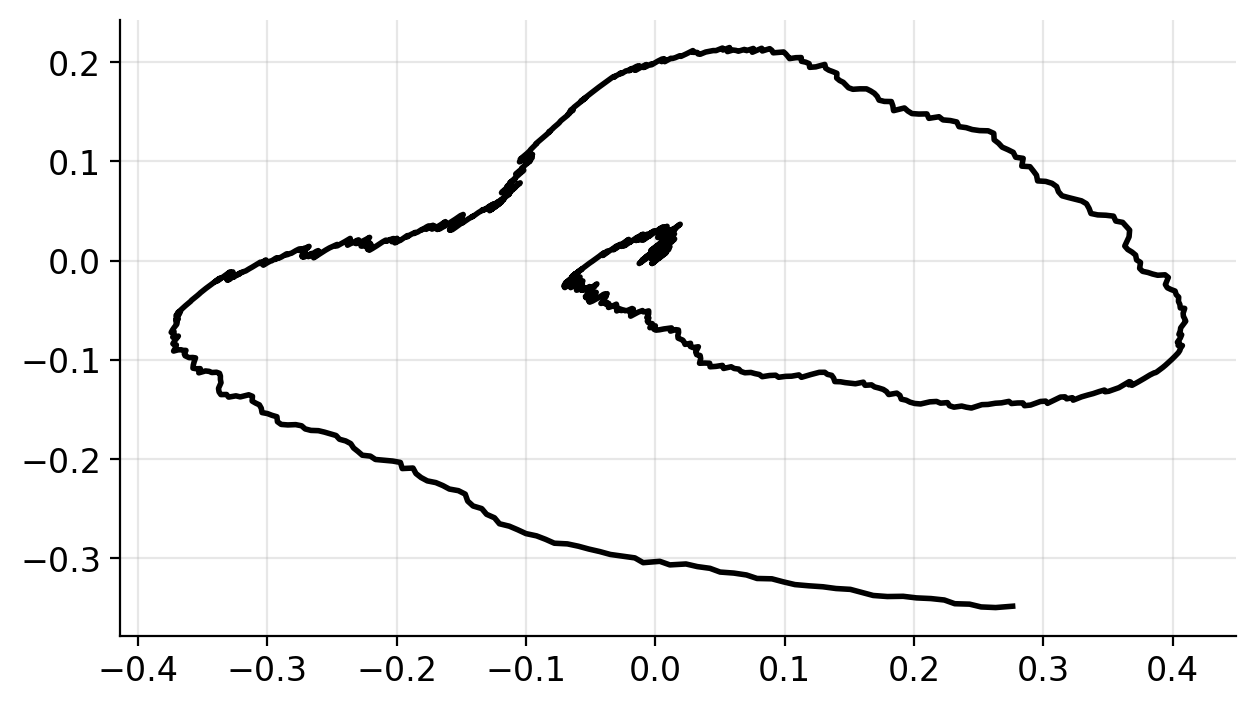

In [566]:
s = 10
innovation_sim = innovation_sims_test[..., s]
latent_test = latent_sims_test[..., s]

plt.plot(*latent_test.T, c="black", linewidth=2)
plt.grid(alpha=0.3)
plt.savefig("sample-run.png", dpi=300, bbox_inches="tight")

## Filter

In [551]:
tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=0)
latent_filter = jnp.einsum("tkd,dk,kd,tk->td", K, 1/S, innovation_sim, tmask)

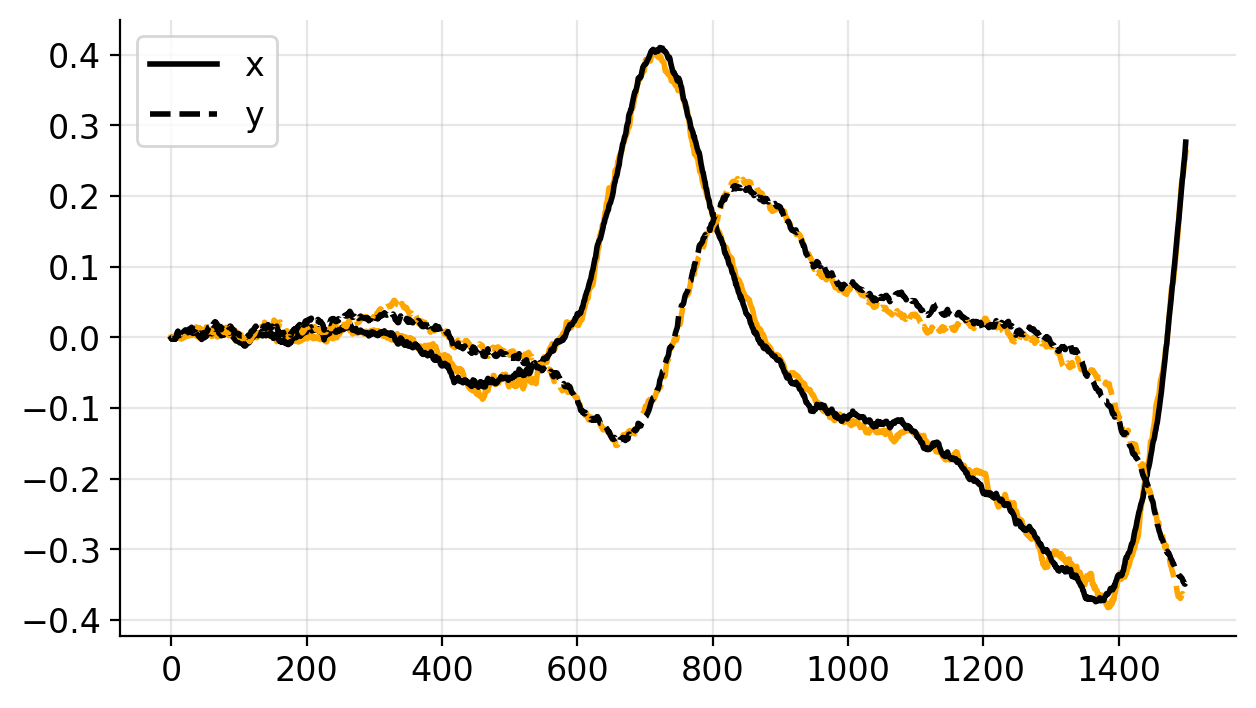

In [559]:
linestyles = ["-", "--"]
coords = ["x", "y"]
for d, (ls, coord) in enumerate(zip(linestyles, coords)):
    plt.plot(latent_filter[:,d], c="orange", linewidth=2, linestyle=ls)
    plt.plot(latent_test[:,d], c="black", linewidth=2, linestyle=ls, label=coord)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("test-sample-filter.png", dpi=300, bbox_inches="tight")

## Smoothing
We begin by computing the BLUP estimate over a sample $y_{1:T}$.

$$
    f_{t|T} = \sum_{k=1}^T{\bf K}_{t,k}\,\varepsilon_{k}
$$

In [553]:
latent_smooth = jnp.einsum("tkd,dk,kd->td", K, 1/S, innovation_sim)

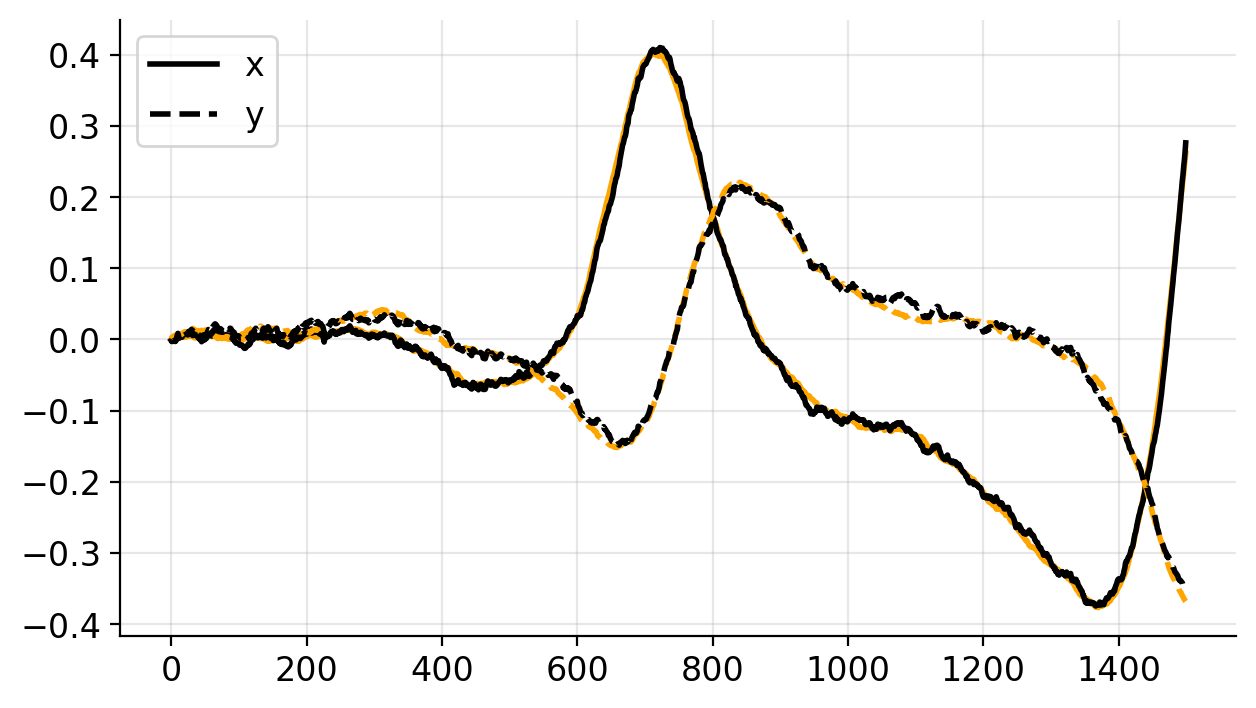

In [560]:
linestyles = ["-", "--"]
for d, (ls, coord) in enumerate(zip(linestyles, coords)):
    plt.plot(latent_smooth[:,d], c="orange", linewidth=2, linestyle=ls)
    plt.plot(latent_test[:,d], c="black", linewidth=2, linestyle=ls, label=coord)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("test-sample-smooth.png", dpi=300, bbox_inches="tight")

## Fixed-lag smoothing

In [561]:
innovation_sims_test.shape

(1500, 2, 100)

In [579]:
lags = np.arange(-100, 100)

lag_errs = {}
for lag in lags:
    tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=lag)
    latent_fixed_lag = jnp.einsum("tkd,dk,kds,tk->tds", K, 1/S, innovation_sims_test, tmask)
    err_sims = jnp.sqrt(jnp.power(latent_sims_test - latent_fixed_lag, 2).mean(axis=0))
    lag_errs[lag] = np.array(err_sims).mean(axis=-1)
lag_errs = pd.DataFrame.from_dict(lag_errs, orient="index", columns=["x", "y"])

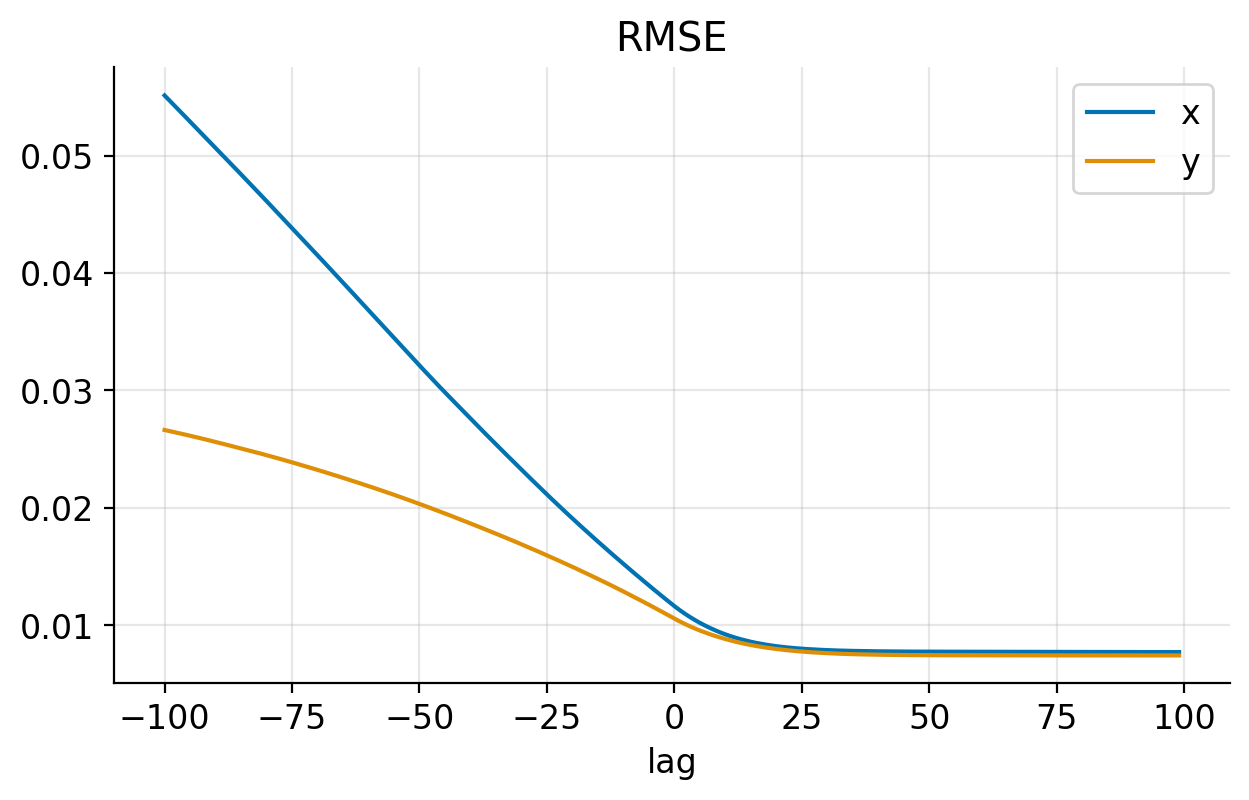

In [581]:
lag_errs.plot()
plt.title("RMSE")
plt.xlabel("lag")
plt.grid(alpha=0.3)
plt.savefig("errs-sample-lag.png", dpi=300, bbox_inches="tight")